# Adaptive Global Income and Growth (AGIG) ETF Optimization

## 1. Setup

### 1.1. Install Dependencies

In [1]:
# It is recommended to run this in your terminal:
# pip install yfinance pymoo tensorflow pandas numpy matplotlib seaborn scikit-learn TA-Lib

# Note: Installing TA-Lib can be tricky. 
# If you have issues, you may need to install the underlying C library first.
# For Windows, you can often find unofficial binaries. For Linux/Mac, use your package manager.

### 1.2. Imports

In [2]:
import warnings
import yfinance as yf
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import Huber

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

# --- Setup --- 
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

## 2. Configuration

In [3]:
# --- Portfolio & Data --- 
PORTFOLIO_TICKERS = [
    'AAPL', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'AMD', 'INTC', 'META',
    'COST', 'PG', 'KO', 'PEP', 'WMT', 'CME', 'AVGO', 'PFE', 'ABBV', 'HD',
    'XOM', 'VDE', 'SCHD', 'VYM', 'VWO', 'VEA', 'GLD', 'SLV', 'FXY', 
    'FDIVX', 'TLT', 'SPLB'
]
BENCHMARK_TICKER = 'SPY'
DATA_PERIOD = '25y'

# --- Feature Engineering ---
LOG_RETURN_CLIP = 0.20 # Clip log returns to +/- 20% to remove extreme outliers

# --- Bi-LSTM Model ---
LOOKBACK_WINDOW = 60 # Days of historical data to use for one prediction
TRAIN_SPLIT = 0.64
VALIDATION_SPLIT = 0.16 # 16% validation, 20% test
LSTM_UNITS = [128, 64, 32]
DROPOUT_RATE = 0.2
EPOCHS = 100
BATCH_SIZE = 32

# --- NSGA-II Optimization ---
POPULATION_SIZE = 100 # Reduced for faster example run, prototype used 500
N_GENERATIONS = 100   # Reduced for faster example run, prototype used 1000
TARGET_DIVIDEND_YIELD = 0.04 # 4% annual dividend yield
MIN_WEIGHT_PER_ASSET = 0.01 # 1% min allocation
MAX_WEIGHT_PER_ASSET = 0.10 # 10% max allocation

# --- Prediction Mode ---
# 'historical': Use model predictions on the test set for backtesting.
# 'future': Generate 30 new forward-looking predictions.
PREDICTION_MODE = 'historical'

## 3. Data Loading and Preprocessing

In [4]:
def load_price_data(tickers, period):
    """Downloads historical 'Close' prices from yfinance and preprocesses them."""
    print(f"Downloading {len(tickers)} tickers for period '{period}'...")
    # Download data
    data = yf.download(tickers, period=period, progress=False)
    
    # Get 'Close' prices and handle missing data
    close_data = pl.from_pandas(data['Close'].reset_index())
    close_data = close_data.drop_nulls()
    close_data = close_data.fill_null(strategy='forward').fill_null(strategy='backward')
    
    # Remove timezone from Date column to ensure consistency
    close_data = close_data.with_columns(
        pl.col('Date').dt.replace_time_zone(None)
    )
    
    print(f"✓ Price data shape: {close_data.shape}")
    return close_data

def load_dividend_data(tickers, price_data):
    """Downloads historical dividend data for the given tickers."""
    print(f"Downloading dividend data for {len(tickers)} tickers...")
    
    # Create a polars DataFrame with the same index as price_data
    date_index = price_data.select(pl.col('Date'))
    dividend_data = date_index.clone()
    for ticker in tickers:
        dividend_data = dividend_data.with_columns(pl.lit(0.0).alias(ticker))

    for ticker in tickers:
        try:
            dividends_series = yf.Ticker(ticker).dividends
            if not dividends_series.empty:
                # Convert pandas series to polars DataFrame
                dividends_df = pl.from_pandas(dividends_series.reset_index())
                dividends_df.columns = ['Date', ticker]
                
                # Remove timezone from Date column to match price_data
                dividends_df = dividends_df.with_columns(
                    pl.col('Date').dt.replace_time_zone(None)
                )
                
                # Left join and coalesce to merge the dividend data correctly
                dividend_data = dividend_data.join(dividends_df, on='Date', how='left', suffix='_new')
                dividend_data = dividend_data.with_columns(
                    pl.coalesce([pl.col(f"{ticker}_new"), pl.col(ticker)]).alias(ticker)
                ).drop(f"{ticker}_new")

        except Exception as e:
            print(f"- Could not retrieve dividend data for {ticker}: {e}")
            
    dividend_data = dividend_data.fill_null(0)
    print(f"✓ Dividend data shape: {dividend_data.shape}")
    return dividend_data

# --- Execute Data Loading ---
all_tickers = PORTFOLIO_TICKERS + [BENCHMARK_TICKER]
price_df = load_price_data(all_tickers, DATA_PERIOD)
dividend_df = load_dividend_data(PORTFOLIO_TICKERS, price_df)

print("\nPrice Data Tail:")
display(price_df.tail(3).to_pandas())
print("\nDividend Data Tail (showing columns with recent dividends):")
# Filter columns with recent dividends, excluding the 'Date' column from the comparison
ticker_cols = [col for col in dividend_df.columns if col != 'Date']
cols_with_dividends = [col for col in ticker_cols if (dividend_df[col][-100:] != 0).any()]
display(dividend_df.select(['Date'] + cols_with_dividends).tail(3).to_pandas())


✓ Price data shape: (3242, 32)
✓ Dividend data shape: (3242, 31)

Price Data Tail:


,Date,AAPL,ABBV,AMD,AMZN,AVGO,CME,COST,FDIVX,FXY,GLD,GOOG,HD,INTC,KO,META,MSFT,NVDA,PEP,PFE,PG,SCHD,SLV,SPLB,SPY,TLT,VDE,VEA,VWO,VYM,WMT,XOM
0,2025-11-17,267.459991,234.000000,240.520004,232.869995,342.649994,279.130005,912.590027,51.700001,59.240002,371.649994,285.600006,358.029999,34.709999,70.680000,602.010010,507.489990,186.600006,147.830002,25.080000,145.820007,27.00,45.470001,22.709999,665.669983,89.089996,127.050003,60.529999,54.220001,139.539993,102.949997,117.680000
1,2025-11-18,267.440002,233.869995,230.289993,222.550003,340.500000,279.279999,895.080017,50.959999,59.150002,374.350006,284.959991,336.480011,34.330002,71.220001,597.690002,493.790009,181.360001,148.770004,25.450001,146.990005,27.16,46.099998,22.719999,660.080017,89.059998,128.149994,59.910000,54.040001,139.509995,101.389999,119.029999
2,2025-11-19,268.559998,232.910004,223.550003,222.690002,354.420013,272.489990,890.599976,50.709999,58.610001,374.959991,292.989990,334.500000,35.110001,71.110001,590.320007,487.119995,186.520004,147.110001,24.879999,146.990005,26.93,46.450001,22.709999,662.630005,88.879997,126.629997,59.709999,53.919998,139.690002,100.610001,117.349998



Dividend Data Tail (showing columns with recent dividends):


,Date,AAPL,GOOG,MSFT,NVDA,META,COST,PG,KO,PEP,WMT,CME,AVGO,PFE,ABBV,HD,XOM,VDE,SCHD,VYM,VWO,VEA,TLT,SPLB
0,2025-11-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-11-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-11-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Feature Engineering

In [5]:
def create_features(price_data, tickers):
    """Generates a representative set of technical analysis features."""
    print(f"Generating features for {len(tickers)} tickers...")
    
    # Convert Polars DataFrame to pandas for processing
    price_data_pd = price_data.to_pandas().set_index('Date')
    
    # We need Open, High, Low, Close for many TA-Lib functions.
    # Let's download the full OHLCV data here.
    ohlcv_data = yf.download(tickers, period='25y', progress=False)
    
    # Collect all feature columns in a dictionary to avoid DataFrame fragmentation
    feature_dict = {}
    
    for ticker in tickers:
        # --- Shift data to prevent look-ahead bias ---
        # All features for day T must be calculated using data from T-1 or earlier.
        high = ohlcv_data[('High', ticker)].shift(1)
        low = ohlcv_data[('Low', ticker)].shift(1)
        close = ohlcv_data[('Close', ticker)].shift(1)
        volume = ohlcv_data[('Volume', ticker)].shift(1)
        
        # --- Momentum & Price-Level Indicators ---
        feature_dict[f'{ticker}_RSI'] = talib.RSI(close)
        macd, macd_signal, macd_hist = talib.MACD(close)
        feature_dict[f'{ticker}_MACD'] = macd
        feature_dict[f'{ticker}_MACD_SIGNAL'] = macd_signal
        feature_dict[f'{ticker}_MACD_HIST'] = macd_hist
        feature_dict[f'{ticker}_ADX'] = talib.ADX(high, low, close)
        feature_dict[f'{ticker}_ROC'] = talib.ROC(close, timeperiod=14) # Rate of Change
        
        # VWAP (Volume Weighted Average Price) - 20-day rolling
        typical_price = (high + low + close) / 3
        tpv = (typical_price * volume).rolling(window=20).sum()
        vol_sum = volume.rolling(window=20).sum()
        feature_dict[f'{ticker}_VWAP'] = tpv / vol_sum
        
        # --- Volatility Indicators ---
        feature_dict[f'{ticker}_ATR'] = talib.ATR(high, low, close)
        upper, middle, lower = talib.BBANDS(close)
        feature_dict[f'{ticker}_BB_WIDTH'] = (upper - lower) / middle
        
        # --- Trend Indicators ---
        feature_dict[f'{ticker}_SMA_50'] = talib.SMA(close, timeperiod=50)
        feature_dict[f'{ticker}_EMA_200'] = talib.EMA(close, timeperiod=200)
        
        # --- Price Lags & Volume ---
        # Note: pct_change(lag) on shifted data correctly calculates the return from T-lag-1 to T-1.
        feature_dict[f'{ticker}_VOL_SMA_20'] = talib.SMA(volume, timeperiod=20)
        for lag in [1, 5, 10, 21]:
            feature_dict[f'{ticker}_LAG_{lag}'] = close.pct_change(lag)
    
    # Create DataFrame efficiently from dictionary
    features_df = pd.DataFrame(feature_dict, index=ohlcv_data.index)
            
    # --- Define Target Variable ---
    # The target is the next day's log return for each portfolio asset
    # This is calculated on the original (non-shifted) price data.
    target_df = np.log(price_data_pd[tickers] / price_data_pd[tickers].shift(1)).shift(-1)
    target_df = target_df.clip(-LOG_RETURN_CLIP, LOG_RETURN_CLIP) # Clip outliers
    
    # --- Combine and clean ---
    # Align features and targets on the same index
    combined_df = pd.concat([features_df, target_df.add_suffix('_TARGET')], axis=1)
    combined_df = combined_df.dropna()
    
    print(f"✓ Feature engineering complete. Shape: {combined_df.shape}")
    return combined_df

# --- Execute Feature Engineering ---
# We only create features for the assets in our portfolio, not the benchmark
features_and_target_df = create_features(price_df, PORTFOLIO_TICKERS)

print("\nFeatures and Target Data Tail:")
display(features_and_target_df.tail(3))


Generating features for 30 tickers...
✓ Feature engineering complete. Shape: (3042, 450)

Features and Target Data Tail:


,AAPL_RSI,AAPL_MACD,AAPL_MACD_SIGNAL,AAPL_MACD_HIST,AAPL_ADX,AAPL_ATR,AAPL_BB_WIDTH,AAPL_SMA_50,AAPL_EMA_200,AAPL_VOL_SMA_20,AAPL_LAG_1,AAPL_LAG_5,AAPL_LAG_10,AAPL_LAG_21,GOOG_RSI,GOOG_MACD,GOOG_MACD_SIGNAL,GOOG_MACD_HIST,GOOG_ADX,GOOG_ATR,GOOG_BB_WIDTH,GOOG_SMA_50,GOOG_EMA_200,GOOG_VOL_SMA_20,GOOG_LAG_1,GOOG_LAG_5,GOOG_LAG_10,GOOG_LAG_21,MSFT_RSI,MSFT_MACD,MSFT_MACD_SIGNAL,MSFT_MACD_HIST,MSFT_ADX,MSFT_ATR,MSFT_BB_WIDTH,MSFT_SMA_50,MSFT_EMA_200,MSFT_VOL_SMA_20,MSFT_LAG_1,MSFT_LAG_5,MSFT_LAG_10,MSFT_LAG_21,NVDA_RSI,NVDA_MACD,NVDA_MACD_SIGNAL,NVDA_MACD_HIST,NVDA_ADX,NVDA_ATR,NVDA_BB_WIDTH,NVDA_SMA_50,NVDA_EMA_200,NVDA_VOL_SMA_20,NVDA_LAG_1,NVDA_LAG_5,NVDA_LAG_10,NVDA_LAG_21,AMZN_RSI,AMZN_MACD,AMZN_MACD_SIGNAL,AMZN_MACD_HIST,AMZN_ADX,AMZN_ATR,AMZN_BB_WIDTH,AMZN_SMA_50,AMZN_EMA_200,AMZN_VOL_SMA_20,AMZN_LAG_1,AMZN_LAG_5,AMZN_LAG_10,AMZN_LAG_21,AMD_RSI,AMD_MACD,AMD_MACD_SIGNAL,AMD_MACD_HIST,AMD_ADX,AMD_ATR,AMD_BB_WIDTH,AMD_SMA_50,AMD_EMA_200,AMD_VOL_SMA_20,AMD_LAG_1,AMD_LAG_5,AMD_LAG_10,AMD_LAG_21,INTC_RSI,INTC_MACD,INTC_MACD_SIGNAL,INTC_MACD_HIST,INTC_ADX,INTC_ATR,INTC_BB_WIDTH,INTC_SMA_50,INTC_EMA_200,INTC_VOL_SMA_20,INTC_LAG_1,INTC_LAG_5,INTC_LAG_10,INTC_LAG_21,META_RSI,META_MACD,META_MACD_SIGNAL,META_MACD_HIST,META_ADX,META_ATR,META_BB_WIDTH,META_SMA_50,META_EMA_200,META_VOL_SMA_20,META_LAG_1,META_LAG_5,META_LAG_10,META_LAG_21,COST_RSI,COST_MACD,COST_MACD_SIGNAL,COST_MACD_HIST,COST_ADX,COST_ATR,COST_BB_WIDTH,COST_SMA_50,COST_EMA_200,COST_VOL_SMA_20,COST_LAG_1,COST_LAG_5,COST_LAG_10,COST_LAG_21,PG_RSI,PG_MACD,PG_MACD_SIGNAL,PG_MACD_HIST,PG_ADX,PG_ATR,PG_BB_WIDTH,PG_SMA_50,PG_EMA_200,PG_VOL_SMA_20,PG_LAG_1,PG_LAG_5,PG_LAG_10,PG_LAG_21,KO_RSI,KO_MACD,KO_MACD_SIGNAL,KO_MACD_HIST,KO_ADX,KO_ATR,KO_BB_WIDTH,KO_SMA_50,KO_EMA_200,KO_VOL_SMA_20,KO_LAG_1,KO_LAG_5,KO_LAG_10,KO_LAG_21,PEP_RSI,PEP_MACD,PEP_MACD_SIGNAL,PEP_MACD_HIST,PEP_ADX,PEP_ATR,PEP_BB_WIDTH,PEP_SMA_50,PEP_EMA_200,PEP_VOL_SMA_20,PEP_LAG_1,PEP_LAG_5,PEP_LAG_10,PEP_LAG_21,WMT_RSI,WMT_MACD,WMT_MACD_SIGNAL,WMT_MACD_HIST,WMT_ADX,WMT_ATR,WMT_BB_WIDTH,WMT_SMA_50,WMT_EMA_200,WMT_VOL_SMA_20,WMT_LAG_1,WMT_LAG_5,WMT_LAG_10,WMT_LAG_21,CME_RSI,CME_MACD,CME_MACD_SIGNAL,CME_MACD_HIST,CME_ADX,CME_ATR,CME_BB_WIDTH,CME_SMA_50,CME_EMA_200,CME_VOL_SMA_20,CME_LAG_1,CME_LAG_5,CME_LAG_10,CME_LAG_21,AVGO_RSI,AVGO_MACD,AVGO_MACD_SIGNAL,AVGO_MACD_HIST,AVGO_ADX,AVGO_ATR,AVGO_BB_WIDTH,AVGO_SMA_50,AVGO_EMA_200,AVGO_VOL_SMA_20,AVGO_LAG_1,AVGO_LAG_5,AVGO_LAG_10,AVGO_LAG_21,PFE_RSI,PFE_MACD,PFE_MACD_SIGNAL,PFE_MACD_HIST,PFE_ADX,PFE_ATR,PFE_BB_WIDTH,PFE_SMA_50,PFE_EMA_200,PFE_VOL_SMA_20,PFE_LAG_1,PFE_LAG_5,PFE_LAG_10,PFE_LAG_21,ABBV_RSI,ABBV_MACD,ABBV_MACD_SIGNAL,ABBV_MACD_HIST,ABBV_ADX,ABBV_ATR,ABBV_BB_WIDTH,ABBV_SMA_50,ABBV_EMA_200,ABBV_VOL_SMA_20,ABBV_LAG_1,ABBV_LAG_5,ABBV_LAG_10,ABBV_LAG_21,HD_RSI,HD_MACD,HD_MACD_SIGNAL,HD_MACD_HIST,HD_ADX,HD_ATR,HD_BB_WIDTH,HD_SMA_50,HD_EMA_200,HD_VOL_SMA_20,HD_LAG_1,HD_LAG_5,HD_LAG_10,HD_LAG_21,XOM_RSI,XOM_MACD,XOM_MACD_SIGNAL,XOM_MACD_HIST,XOM_ADX,XOM_ATR,XOM_BB_WIDTH,XOM_SMA_50,XOM_EMA_200,XOM_VOL_SMA_20,XOM_LAG_1,XOM_LAG_5,XOM_LAG_10,XOM_LAG_21,VDE_RSI,VDE_MACD,VDE_MACD_SIGNAL,VDE_MACD_HIST,VDE_ADX,VDE_ATR,VDE_BB_WIDTH,VDE_SMA_50,VDE_EMA_200,VDE_VOL_SMA_20,VDE_LAG_1,VDE_LAG_5,VDE_LAG_10,VDE_LAG_21,SCHD_RSI,SCHD_MACD,SCHD_MACD_SIGNAL,SCHD_MACD_HIST,SCHD_ADX,SCHD_ATR,SCHD_BB_WIDTH,SCHD_SMA_50,SCHD_EMA_200,SCHD_VOL_SMA_20,SCHD_LAG_1,SCHD_LAG_5,SCHD_LAG_10,SCHD_LAG_21,VYM_RSI,VYM_MACD,VYM_MACD_SIGNAL,VYM_MACD_HIST,VYM_ADX,VYM_ATR,VYM_BB_WIDTH,VYM_SMA_50,VYM_EMA_200,VYM_VOL_SMA_20,VYM_LAG_1,VYM_LAG_5,VYM_LAG_10,VYM_LAG_21,VWO_RSI,VWO_MACD,VWO_MACD_SIGNAL,VWO_MACD_HIST,VWO_ADX,VWO_ATR,VWO_BB_WIDTH,VWO_SMA_50,VWO_EMA_200,VWO_VOL_SMA_20,VWO_LAG_1,VWO_LAG_5,VWO_LAG_10,VWO_LAG_21,VEA_RSI,VEA_MACD,VEA_MACD_SIGNAL,VEA_MACD_HIST,VEA_ADX,VEA_ATR,VEA_BB_WIDTH,VEA_SMA_50,VEA_EMA_200,VEA_VOL_SMA_20,VEA_LAG_1,VEA_LAG_5,VEA_LAG_10,VEA_LAG_21,GLD_RSI,GLD_MACD,GLD_MACD_SIGNAL,GLD_MACD_HIST,GLD_ADX,GLD_ATR,GLD_BB_WIDTH,GLD_SMA_50,GLD_EMA_200,GLD_VOL_SMA_20,GLD_LAG_1,GLD_LAG_5,GLD_LAG_1

## 5. Bi-LSTM Model

In [7]:
# --- 1. Data Preparation ---
print("Preparing data for LSTM model...")
feature_cols = [c for c in features_and_target_df.columns if not c.endswith('_TARGET')]
target_cols = [c for c in features_and_target_df.columns if c.endswith('_TARGET')]

X = features_and_target_df[feature_cols].values
y = features_and_target_df[target_cols].values

feature_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler(feature_range=(-1, 1))

X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y)

# --- 2. Create Sequences ---
def create_sequences(X_data, y_data, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - window_size):
        X_seq.append(X_data[i:(i + window_size)])
        y_seq.append(y_data[i + window_size])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, LOOKBACK_WINDOW)

# --- 3. Train/Val/Test Split (Temporal) ---
n_samples = len(X_seq)
train_end = int(n_samples * TRAIN_SPLIT)
val_end = int(n_samples * (TRAIN_SPLIT + VALIDATION_SPLIT))

X_train, y_train = X_seq[:train_end], y_seq[:train_end]
X_val, y_val = X_seq[train_end:val_end], y_seq[train_end:val_end]
X_test, y_test = X_seq[val_end:], y_seq[val_end:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# --- 4. Model Architecture & Training ---
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

@tf.keras.utils.register_keras_serializable()
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        return K.sum(output, axis=1)

input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

def create_bilstm_attention_model(input_shape, output_shape, lstm_units, dropout_rate):
    inputs = tf.keras.Input(shape=input_shape)
    x = Bidirectional(LSTM(lstm_units[0], return_sequences=True))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units[1], return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)
    x = Attention()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(output_shape, activation='tanh')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=Huber())
    return model

model = create_bilstm_attention_model(input_shape, output_shape, LSTM_UNITS, DROPOUT_RATE)
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('bilstm_best_model.keras', save_best_only=True, monitor='val_loss')


Preparing data for LSTM model...
X_train shape: (1908, 60, 420), y_train shape: (1908, 30)
X_val shape: (477, 60, 420), y_val shape: (477, 30)
X_test shape: (597, 60, 420), y_test shape: (597, 30)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 420)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 256)        │       562,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 60, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │           188 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 730,586 (2.79 MB)

 Trainable params: 730,586 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\n--- Starting Model Training ---")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)
print("--- Model Training Complete ---")

# --- 5. Plot Training History ---
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Huber Loss')
plt.legend()
plt.show()

## 6. NSGA-II Optimization

Generating predictions from the trained Bi-LSTM model...
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
✓ Predicted returns generated. Shape: (597, 30)

--- Starting NSGA-II Optimization ---
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     17 |  0.000000E+00 |  9.658940E-17 |             - |             -
     2 |      200 |     32 |  0.000000E+00 |  0.000000E+00 |  0.1050179871 |         ideal
     3 |      300 |     44 |  0.000000E+00 |  0.000000E+00 |  0.2053855852 |         nadir
     4 |      400 |     42 |  0.000000E+00 |  0.000000E+00 |  0.0252301327 |         ideal
     5 |      500 |     55 |  0.000000E+00 |  0.000000E+00 |  0.0231762629 |         ideal
     6 |      600 |     61 |  0.000000E+00 |  0.000000E+00 |  0.2795329794 |         ideal
     7 |      700 |     60 |  0.000000E+00 |  0.000000E+00 |  0.0195050627 |         ideal
     8 |      800 |     71 |  0.000000E+00 |  0.000000E+00 |  0.0599639028 |         ide

,Return,Dividend,Volatility,CVaR_95,Sharpe,AAPL,GOOG,MSFT,NVDA,AMZN,AMD,INTC,META,COST,PG,KO,PEP,WMT,CME,AVGO,PFE,ABBV,HD,XOM,VDE,SCHD,VYM,VWO,VEA,GLD,SLV,FXY,FDIVX,TLT,SPLB
40,0.351882,1.834389,0.015465,0.036425,21.460157,0.011899,0.016741,0.059332,0.032591,0.008707,0.075340,0.062207,0.013005,0.074895,0.063529,0.050609,0.007980,0.078526,0.030665,0.014099,0.060765,0.011902,0.024418,0.012710,0.013538,0.063498,0.017963,0.008117,0.013614,0.060393,0.011734,0.011070,0.012445,0.056702,0.021005
75,0.533496,2.142865,0.024716,0.051897,20.775909,0.026178,0.015476,0.008240,0.032359,0.016842,0.074231,0.050605,0.011754,0.070374,0.073648,0.050209,0.026065,0.066262,0.076324,0.074084,0.061947,0.018228,0.021749,0.008585,0.025647,0.012844,0.016663,0.025368,0.019493,0.013390,0.015698,0.011150,0.008197,0.051326,0.017065
83,0.607896,2.254232,0.028474,0.074994,20.646820,0.008797,0.012123,0.012662,0.026889,0.017311,0.078900,0.063472,0.012013,0.071887,0.064624,0.052196,0.075285,0.013919,0.072116,0.069777,0.060819,0.012295,0.021863,0.016856,0.013114,0.026879,0.019560,0.026318,0.016044,0.025362,0.011317,0.012057,0.008471,0.058567,0.018507
73,0.405268,1.676444,0.018663,0.080797,20.642986,0.008933,0.055199,0.009153,0.035123,0.017434,0.080790,0.055704,0.012578,0.045340,0.065461,0.022519,0.011138,0.074712,0.034365,0.080590,0.067391,0.018349,0.023659,0.008706,0.019762,0.015136,0.015835,0.015215,0.022561,0.013516,0.016993,0.057225,0.008920,0.066303,0.021389
14,0.409697,1.633676,0.019107,0.080223,20.395826,0.009278,0.051677,0.008569,0.032882,0.059343,0.075635,0.052149,0.011776,0.042447,0.061284,0.020892,0.010165,0.072981,0.032179,0.075448,0.063091,0.026210,0.022136,0.010489,0.018501,0.014261,0.020533,0.014244,0.021121,0.011742,0.015828,0.053573,0.008351,0.063189,0.020024


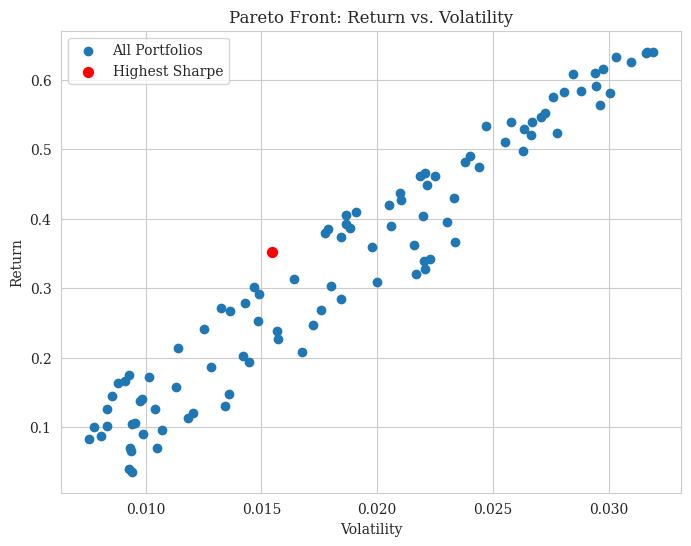

In [8]:
# --- 1. Generate Predictions from Trained Model ---
print("Generating predictions from the trained Bi-LSTM model...")
# Load the best model saved during training
best_model = tf.keras.models.load_model('bilstm_best_model.keras', custom_objects={'Huber': Huber, 'Attention': Attention})

# Predict on the test set
test_predictions_scaled = best_model.predict(X_test)

# Inverse transform the predictions and actuals to get log returns
predicted_log_returns = target_scaler.inverse_transform(test_predictions_scaled)
actual_log_returns = target_scaler.inverse_transform(y_test)

# Convert log returns to simple returns
predicted_simple_returns = np.expm1(predicted_log_returns)
actual_simple_returns = np.expm1(actual_log_returns)

predicted_returns_df = pd.DataFrame(predicted_simple_returns, columns=PORTFOLIO_TICKERS)

print(f"✓ Predicted returns generated. Shape: {predicted_returns_df.shape}")

# --- 2. Define the NSGA-II Optimization Problem ---
class PortfolioOptimizationProblem(Problem):
    def __init__(self, mu, sigma, dividend_yields, predicted_returns_timeseries, min_weight, max_weight, target_dividend):
        super().__init__(n_var=len(mu),
                         n_obj=4,
                         n_constr=2, # sum of weights = 1, dividend yield >= target
                         xl=min_weight,
                         xu=max_weight)
        self.mu = mu
        self.sigma = sigma
        self.dividend_yields = dividend_yields
        self.predicted_returns_timeseries = predicted_returns_timeseries # For CVaR calculation
        self.target_dividend = target_dividend

    def _evaluate(self, x, out, *args, **kwargs):
        # Normalize weights to ensure they sum to 1
        weights = x / x.sum(axis=1, keepdims=True)

        # 1. Maximize Annualized Return (minimize negative return)
        # Using matrix multiplication: mu_portfolio = weights.T @ mu
        f1 = -np.dot(weights, self.mu) * 252

        # 2. Maximize Dividend Yield (minimize negative yield)
        f2 = -np.sum(weights * self.dividend_yields, axis=1)

        # 3. Minimize Annualized Volatility
        # Using matrix multiplication: sigma_portfolio = sqrt(weights.T @ Sigma @ weights)
        portfolio_volatility = [np.sqrt(np.dot(w.T, np.dot(self.sigma, w))) for w in weights]
        f3 = np.array(portfolio_volatility) * np.sqrt(252)

        # 4. Minimize CVaR (95%)
        # CVaR is harder to express with matrix algebra, so we use the predicted timeseries here
        portfolio_returns_ts = (self.predicted_returns_timeseries @ weights.T)
        q = np.percentile(portfolio_returns_ts, 5, axis=0)
        cvar = [np.mean(pr[pr <= q_val]) for pr, q_val in zip(portfolio_returns_ts.T, q)]
        f4 = -np.array(cvar) * 252 # Minimize CVaR (less negative is better)

        out["F"] = np.column_stack([f1, f2, f3, f4])
        
        # --- Constraints ---
        # Constraint 1: sum of weights must be 1 (pymoo handles this as g <= 0)
        g1 = np.abs(np.sum(weights, axis=1) - 1.0)
        
        # Constraint 2: portfolio dividend yield must be >= target
        g2 = self.target_dividend - np.sum(weights * self.dividend_yields, axis=1)
        
        out["G"] = np.column_stack([g1, g2])

# --- 3. Run the Optimization ---
print("\n--- Starting NSGA-II Optimization ---")
# Calculate average annual dividend yield for each asset
# Convert polars DFs to pandas for this section
price_df_pd = price_df.to_pandas().set_index('Date')
dividend_df_pd = dividend_df.to_pandas().set_index('Date')

# --- Prepare inputs for the optimizer ---
# Expected Returns (mu) from Bi-LSTM predictions
mu = predicted_returns_df.mean().values

# Expected Covariance (Sigma) from 60-day historical data before the test period
cov_start_date = features_and_target_df.index[val_end] # Start of test period
cov_period_returns = price_df_pd.loc[:cov_start_date, PORTFOLIO_TICKERS].pct_change().dropna().tail(60)
sigma = cov_period_returns.cov().values

n_years = len(price_df_pd.index.year.unique())
avg_annual_yield = (dividend_df_pd.sum() / n_years).values

problem = PortfolioOptimizationProblem(mu, sigma,
                                     avg_annual_yield,
                                     predicted_returns_df.values, # Pass full timeseries for CVaR
                                     MIN_WEIGHT_PER_ASSET,
                                     MAX_WEIGHT_PER_ASSET,
                                     TARGET_DIVIDEND_YIELD)

algorithm = NSGA2(pop_size=POPULATION_SIZE)

res = minimize(problem,
               algorithm,
               ('n_gen', N_GENERATIONS),
               seed=1,
               verbose=True)

print("--- Optimization Complete ---")

# --- 4. Process and Display Results ---
pareto_weights = res.X
pareto_objectives = res.F

# Normalize weights again to be safe
pareto_weights = pareto_weights / pareto_weights.sum(axis=1, keepdims=True)

pareto_front_df = pd.DataFrame({
    'Return': -pareto_objectives[:, 0],
    'Dividend': -pareto_objectives[:, 1],
    'Volatility': pareto_objectives[:, 2],
    'CVaR_95': -pareto_objectives[:, 3]
})
pareto_front_df['Sharpe'] = (pareto_front_df['Return'] - 0.02) / pareto_front_df['Volatility'] # Assuming 2% risk-free rate

weights_df = pd.DataFrame(pareto_weights, columns=PORTFOLIO_TICKERS)
pareto_results = pd.concat([pareto_front_df, weights_df], axis=1)

print("\nPareto Front Optimal Portfolios:")
display(pareto_results.sort_values('Sharpe', ascending=False).head())

# --- 5. Visualize the Pareto Front ---
plot = Scatter(title = "Pareto Front: Return vs. Volatility",
               labels=["Volatility", "Return"],
               legend=True)
plot.add(pareto_objectives[:, [2, 0]] * np.array([1, -1]), label="All Portfolios")

# Highlight the portfolio with the highest Sharpe ratio
best_sharpe_idx = pareto_results['Sharpe'].idxmax()
best_sharpe_portfolio = pareto_objectives[best_sharpe_idx, [2, 0]] * np.array([1, -1])
plot.add(best_sharpe_portfolio, color="red", s=50, label="Highest Sharpe")

plot.show()

## 7. Backtesting

Selecting portfolio with the highest Sharpe Ratio for backtesting...

Selected Portfolio Weights (allocations > 1%):


WMT      0.078526
AMD      0.075340
COST     0.074895
PG       0.063529
SCHD     0.063498
INTC     0.062207
PFE      0.060765
GLD      0.060393
MSFT     0.059332
TLT      0.056702
KO       0.050609
NVDA     0.032591
CME      0.030665
HD       0.024418
SPLB     0.021005
VYM      0.017963
GOOG     0.016741
AVGO     0.014099
VEA      0.013614
VDE      0.013538
META     0.013005
XOM      0.012710
FDIVX    0.012445
ABBV     0.011902
AAPL     0.011899
SLV      0.011734
FXY      0.011070
Name: 40, dtype: float64


Backtest Performance Summary:


,Optimized Portfolio,Benchmark (SPY)
Cumulative Return,60.22%,55.15%
Annualized Return,20.73%,19.77%
Annualized Volatility,12.88%,15.73%
Sharpe Ratio,1.45,1.13
Max Drawdown,-14.32%,-18.76%


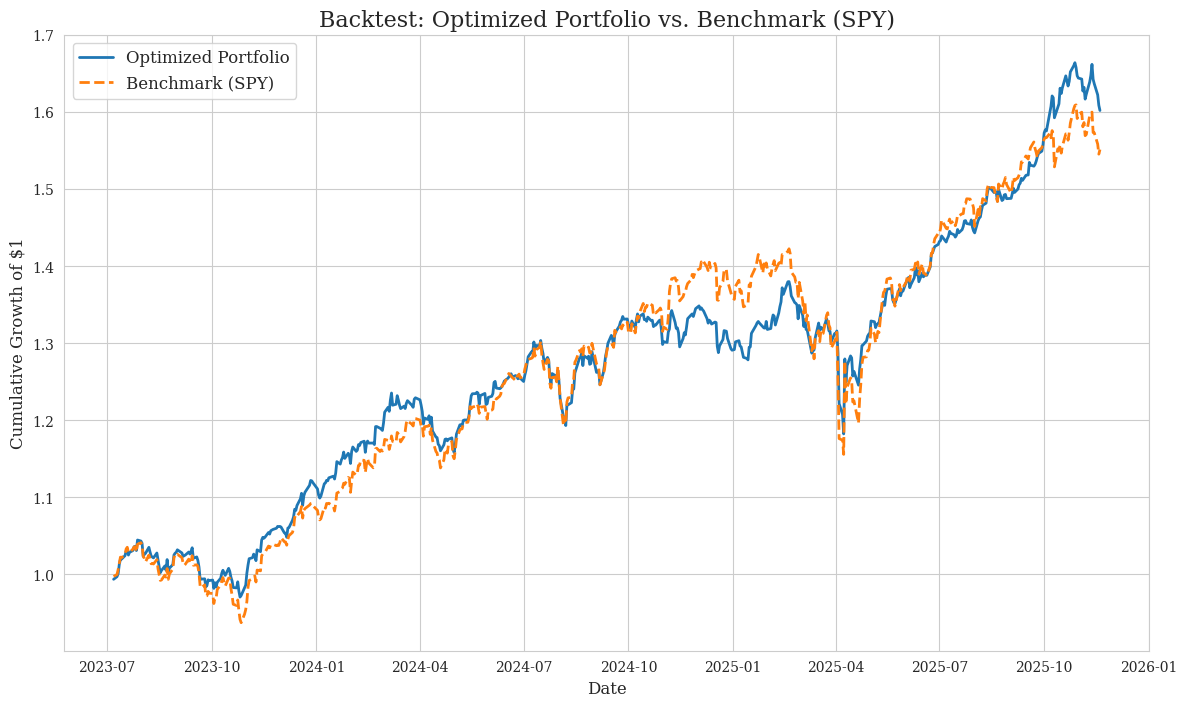

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Select the Best Portfolio for Backtesting ---
print("Selecting portfolio with the highest Sharpe Ratio for backtesting...")
best_sharpe_idx = pareto_results['Sharpe'].idxmax()
selected_portfolio = pareto_results.loc[best_sharpe_idx]
selected_weights = selected_portfolio[PORTFOLIO_TICKERS]

print("\nSelected Portfolio Weights (allocations > 1%):")
display(selected_weights[selected_weights > 0.01].sort_values(ascending=False))

# --- 2. Calculate Historical Performance ---
# Use the ACTUAL returns from the test period, not the predicted returns
test_dates_start = features_and_target_df.index[val_end + LOOKBACK_WINDOW]

# Removed redundant calculations. Assuming 'price_df_pd' is the correct DataFrame.
actual_returns_test = price_df_pd.loc[test_dates_start:, PORTFOLIO_TICKERS].pct_change().dropna()
benchmark_returns_test = price_df_pd.loc[test_dates_start:, BENCHMARK_TICKER].pct_change().dropna()

# Align indices before matrix multiplication
aligned_weights = selected_weights.values
aligned_returns, aligned_benchmark = actual_returns_test.align(benchmark_returns_test, join='inner', axis=0)

portfolio_historical_returns = (aligned_returns * aligned_weights).sum(axis=1)

# --- 3. Calculate Performance Metrics ---
def calculate_metrics(returns, risk_free_rate=0.02):
    """Calculates key performance metrics for a series of returns."""
    if returns.empty:
        return pd.Series({k: 'N/A' for k in ['Cumulative Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown']})
    
    cumulative_return = (1 + returns).prod() - 1
    annualized_return = returns.mean() * 252
    annualized_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else 0
    
    # Max Drawdown Calculation
    cumulative_wealth = (1 + returns).cumprod()
    peak = cumulative_wealth.cummax()
    drawdown = (cumulative_wealth - peak) / peak
    max_drawdown = drawdown.min()
    
    return pd.Series({
        'Cumulative Return': f"{cumulative_return:.2%}",
        'Annualized Return': f"{annualized_return:.2%}",
        'Annualized Volatility': f"{annualized_volatility:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.2f}",
        'Max Drawdown': f"{max_drawdown:.2%}"
    })

# Define the risk-free rate as a constant for clarity
RISK_FREE_RATE = 0.02 
portfolio_metrics = calculate_metrics(portfolio_historical_returns, risk_free_rate=RISK_FREE_RATE)
benchmark_metrics = calculate_metrics(aligned_benchmark, risk_free_rate=RISK_FREE_RATE)

performance_summary = pd.DataFrame({'Optimized Portfolio': portfolio_metrics, 'Benchmark (SPY)': benchmark_metrics})

print("\nBacktest Performance Summary:")
display(performance_summary)

# --- 5. Visualize Performance ---
plt.figure(figsize=(14, 8))

# Use the pre-aligned returns series for consistency and robustness
cumulative_portfolio_returns = (1 + portfolio_historical_returns).cumprod()
cumulative_benchmark_returns = (1 + aligned_benchmark).cumprod()

plt.plot(cumulative_portfolio_returns.index, cumulative_portfolio_returns, label='Optimized Portfolio', lw=2)
plt.plot(cumulative_benchmark_returns.index, cumulative_benchmark_returns, label='Benchmark (SPY)', linestyle='--', lw=2)

plt.title('Backtest: Optimized Portfolio vs. Benchmark (SPY)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Growth of $1', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
